In [ ]:
import numpy as np
import time
import sys
import os
import random
from skimage import io
import pandas as pd
from matplotlib import pyplot as plt
from shutil import copyfile

import cv2
import tensorflow as tf

In [ ]:
base_path = '~/Object-detection-using-Faster-RCNN/data/'
image_links = 'train-images-boxable.csv'
annot_box = 'train-annotations-bbox.csv'
class_labels = 'class-descriptions-boxable.csv'

In [15]:
df_image_links = pd.read_csv(base_path+image_links)

,image_name,image_url
0,e39871fd9fd74f55.jpg,https://requestor-proxy.figure-eight.com/figur...
1,f18b91585c4d3f3e.jpg,https://requestor-proxy.figure-eight.com/figur...
2,ede6e66b2fb59aab.jpg,https://requestor-proxy.figure-eight.com/figur...
3,ed600d57fcee4f94.jpg,https://requestor-proxy.figure-eight.com/figur...
4,ff47e649b23f446d.jpg,https://requestor-proxy.figure-eight.com/figur...


In [14]:
df_annot_box = pd.read_csv(base_path+annot_box)

,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,IsGroupOf,IsDepiction,IsInside
0,000002b66c9c498e,xclick,/m/01g317,1,0.012500,0.195312,0.148438,0.587500,0,1,0,0,0
1,000002b66c9c498e,xclick,/m/01g317,1,0.025000,0.276563,0.714063,0.948438,0,1,0,0,0
2,000002b66c9c498e,xclick,/m/01g317,1,0.151562,0.310937,0.198437,0.590625,1,0,0,0,0
3,000002b66c9c498e,xclick,/m/01g317,1,0.256250,0.429688,0.651563,0.925000,1,0,0,0,0
4,000002b66c9c498e,xclick,/m/01g317,1,0.257812,0.346875,0.235938,0.385938,1,0,0,0,0


In [87]:
df_class_labels = pd.read_csv(base_path+class_labels,header=None)
df_class_labels.columns=['id','name']
df_class_labels.head(25)

,id,name
0,/m/011k07,Tortoise
1,/m/011q46kg,Container
2,/m/012074,Magpie
3,/m/0120dh,Sea turtle
4,/m/01226z,Football
5,/m/012n7d,Ambulance
6,/m/012w5l,Ladder
7,/m/012xff,Toothbrush
8,/m/012ysf,Syringe
9,/m/0130jx,Sink


In [157]:
def plot_org_img_with_boxes(image_name):
    temp = df_image_links[df_image_links['image_name']==image_name]
    img_url = temp['image_url'].values[0]
    img_id = image_name[:16]
    
    img = io.imread(img_url)
    
    height, width, _ = img.shape
    plt.figure(figsize=(15,10))
    plt.subplot(1,2,1)
    plt.title('Original Image')
    plt.imshow(img)
    boxes = df_annot_box[df_annot_box['ImageID']==img_id]
    img_bbox = img.copy()
    for index, row in boxes.iterrows():
        xmin,xmax,ymin,ymax = row['XMin'],row['XMax'],row['YMin'],row['YMax']
        xmin,xmax,ymin,ymax = int(xmin*width),int(xmax*width),int(ymin*height),int(ymax*height)
        label_name = row['LabelName']
        
        temp_df = df_class_labels[df_class_labels['id']==label_name]
        class_of_box = temp_df['name'].values[0]
        
        cv2.rectangle(img_bbox,(xmin,ymin),(xmax,ymax),(0,255,0),2)
        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(img_bbox,class_of_box,(xmin,ymin-10), font, 1,(0,255,0),2)
    plt.subplot(1,2,2)
    plt.title('Image with Bounding Box')
    plt.imshow(img_bbox)
    plt.show()
    

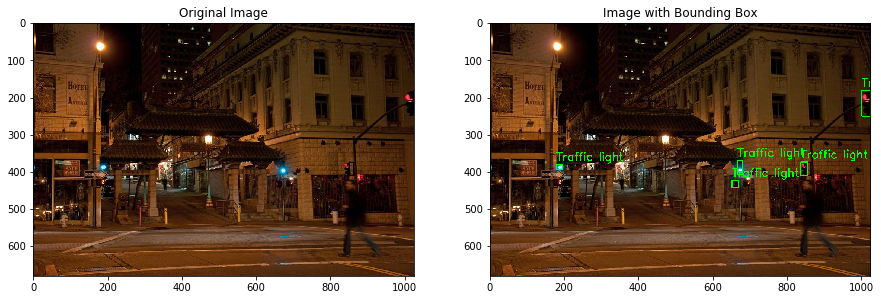

In [158]:
plot_org_img_with_boxes('08aca675c617d832.jpg')

In [56]:
#df_class_labels.head(25)

In [24]:
def create_csv(which_class, num_rows,save=False,save_path ='~/Object-detection-using-Faster-RCNN/createddata/'):
    """Input: 
    which_class(str): one of 600 classes available in the dataset
    num_rows(int): how many rows you want your csv to be could potentially be less than inputted if not that many in data
    
    Returns: 
    Df with num_rows randomly chosen number of rows
    if save==True: saves it as a csv in save_path + which_class_1000.csv
    
    """
    class_id = df_class_labels[df_class_labels['name']==which_class].values[0][0] #collect the class_id value 
    num_total_pics = df_annot_box[df_annot_box['LabelName']==class_id] #select all the annotation boxes with that id value
    print('Total amount of {} in data'.format(which_class))
    print(len(num_total_pics))
    
    print('Number of unique pictures featuring atleast one of {}'.format(which_class))
    num_unique_pics_of_class = np.unique(num_total_pics['ImageID']) #remove duplicate images from the df, 
    #such as smooshing down a picture that has 2 birds to one value
    print(len(num_unique_pics_of_class))
    random_rows = np.random.choice(num_unique_pics_of_class,num_rows,replace=False)#randomly choose Num_rows
    array_append_jpg = [df_image_links[df_image_links['image_name']==name+'.jpg'] for name in random_rows]
    df = pd.DataFrame()
    for i in range(len(array_append_jpg)):
        df = df.append(array_append_jpg[i], ignore_index = True)
    if save:
        df.to_csv(save_path + '{}_1000.csv'.format(which_class))
    
    return df

In [88]:
test = create_csv('Traffic light',1000,save=True)

Total amount of Traffic light in data
7426
Number of unique pictures featuring atleast one of Traffic light
1774


In [ ]:
#extract class id for classes of interest
bird = df_class_labels[df_class_labels['name']=='Bird'].values[0][0]
traffic_light = df_class_labels[df_class_labels['name']=='Traffic light'].values[0][0]
football = df_class_labels[df_class_labels['name']=='Football'].values[0][0]

In [ ]:
num_bird_in_data = df_annot_box[df_annot_box['LabelName']==bird]
num_traffic_light_in_data = df_annot_box[df_annot_box['LabelName']==traffic_light]
num_football_in_data = df_annot_box[df_annot_box['LabelName']==football]

print('Total amount of obj in data')
print(len(num_bird_in_data))
print(len(num_traffic_light_in_data))
print(len(num_football_in_data))

print('Number of unique pictures featuring atleast one of obj')
unique_bird = np.unique(num_bird_in_data['ImageID'])
unique_traffic_light = np.unique(num_traffic_light_in_data['ImageID'])
unique_football = np.unique(num_football_in_data['ImageID'])
print(len(unique_bird))
print(len(unique_traffic_light))
print(len(unique_football))


In [ ]:
bird_random_choice = np.random.choice(unique_bird,1000,replace=False)
traffic_light_random_choice = np.random.choice(unique_traffic_light,1000,replace=False)
football_random_choice = np.random.choice(unique_bird,1000,replace=False)

In [ ]:
bird_url_df = [df_image_links[df_image_links['image_name']==name+'.jpg'] for name in bird_random_choice]
traffic_light_url_df = [df_image_links[df_image_links['image_name']==name+'.jpg'] for name in traffic_light_random_choice]
football_url_df = [df_image_links[df_image_links['image_name']==name+'.jpg'] for name in football_random_choice]

In [102]:
bird_url_df[0]

,image_name,image_url
27961,f73e9107f6dbd42a.jpg,https://requestor-proxy.figure-eight.com/figur...


In [103]:
football_url_df[0]

,image_name,image_url
85475,f78c9cfb05a0a7fa.jpg,https://requestor-proxy.figure-eight.com/figur...


In [28]:
bird_df = pd.DataFrame()
traffic_df= pd.DataFrame()
football_df=pd.DataFrame()
for i in range(len(bird_url_df)):
    bird_df = bird_df.append(bird_url_df[i], ignore_index = True)
    traffic_df = traffic_df.append(traffic_light_url_df[i], ignore_index = True)
    football_df = football_df.append(football_url_df[i], ignore_index = True)

NameError: name 'bird_url_df' is not defined

In [113]:
save_path = '~/Object-detection-using-Faster-RCNN/createddata/'

In [114]:
# bird_df.to_csv(save_path + 'bird_1000.csv')
# traffic_df.to_csv(save_path + 'traffic_lights_1000.csv')
# football_df.to_csv(save_path + 'football_1000.csv')

In [27]:
bird_df[0]

NameError: name 'bird_df' is not defined

In [35]:
bird_df = pd.read_csv('../createddata/bird_1000.csv')
traffic_df = pd.read_csv('../createddata/traffic_lights_1000.csv')
football_df = pd.read_csv('../createddata/football_1000.csv')
bird_df.drop('Unnamed: 0',axis=1,inplace=True)
traffic_df.drop('Unnamed: 0',axis=1,inplace=True)
football_df.drop('Unnamed: 0',axis=1,inplace=True)

In [52]:
urls = [bird_df['image_url'].values,traffic_df['image_url'].values,football_df['image_url'].values]

In [68]:
def download_images(csv_file_path, save_file_path, type_of_class):
    df = pd.read_csv(csv_file_path)
    if len(df.columns) >=3:
        df.drop('Unnamed: 0',axis=1,inplace=True)
    urls = df['image_url'].values
    directory = save_file_path + type_of_class
    os.mkdir(directory)
    for url in urls:
        img = io.imread(url)
        file_name=url[-20:]
        io.imsave(directory+'/'+file_name, img)
    
    

In [89]:
#download_images(csv_file_path='../createddata/football_1000.csv',save_file_path='../createddata/images/',type_of_class='Football')
download_images(csv_file_path='../createddata/Traffic light_1000.csv',save_file_path='../createddata/images/',type_of_class='Traffic_light')




KeyError: <class 'numpy.object_'>

In [90]:
import glob
lst = glob.glob('../createddata/images/Traffic_light/*.jpg')
len(lst)

699

In [91]:
# base_save_path='../createddata/images/'
# classes = ['Bird','Traffic_light','Football']

# for i in range(len(classes)):
#     directory = base_save_path+classes[i]
#     os.mkdir(directory)
#     save_dir = directory
#     for url in urls[i]:
#         img = io.imread(url)
#         file_name =  url[-20:]
#         saved_path = base_save_path+classes[i]+'/'+file_name
#         io.imsave(saved_path, img)

In [92]:
train_path = '../createddata/train/'
test_path = '../createddata/test/'
os.mkdir(train_path)
os.mkdir(test_path)

In [111]:
train_path = '../createddata/train/'
test_path = '../createddata/test/'
# os.mkdir(train_path)
# os.mkdir(test_path)
def split_train_test(file_path_to_imgs, percentage_split=.8, save_path_train = '../createddata/train/',save_path_test = '../createddata/test/'):
    imgs = os.listdir(file_path_to_imgs)
    imgs = [f for f in imgs if not f.startswith('.')]
    random.seed(1)
    random.shuffle(imgs)
    num_of_train_imgs = int(len(imgs)*percentage_split)
    num_of_test_imgs =len(imgs)-int(len(imgs)*(1-percentage_split))
    train_imgs = imgs[:num_of_train_imgs]
    test_imgs = imgs[num_of_test_imgs:]
    for val in train_imgs:
        img_loc = file_path_to_imgs + val
        save_loc = save_path_train+val
        copyfile(img_loc, save_loc)
    for val in test_imgs:
        img_loc = file_path_to_imgs + val
        save_loc = save_path_test+val
        copyfile(img_loc, save_loc)

In [108]:
split_train_test('../createddata/images/Bird/')

800
801


In [113]:
print(len(os.listdir('../createddata/train')))
len(os.listdir('../createddata/test'))

2159


537

In [112]:
split_train_test('../createddata/images/Football/')
split_train_test('../createddata/images/Traffic_light/')

In [142]:
def create_df_out_of_image_folders(path,names_of_classes=[]):
    class_id = []
    for val in names_of_classes:
        class_id.append(df_class_labels[df_class_labels['name']==val].values[0][0])
    df = pd.DataFrame(columns=['FileName', 'XMin', 'XMax', 'YMin', 'YMax', 'ClassName'])
    train_imgs = os.listdir(path)
    train_imgs = [name for name in train_imgs if not name.startswith('.')]
    for i in range(len(train_imgs)):
        sys.stdout.write('Parse train_imgs ' + str(i) + '; Number of boxes: ' + str(len(df)) + '\r')
        sys.stdout.flush()
        img_name = train_imgs[i]
        img_id = img_name[0:16]
        tmp_df = df_annot_box[df_annot_box['ImageID']==img_id]
        for index,row in tmp_df.iterrows():
            labelname=row['LabelName']
            for val in range(len(names_of_classes)):
                if labelname == class_id[val]:
                    df = df.append({'FileName': img_name, 
                                            'XMin': row['XMin'], 
                                            'XMax': row['XMax'], 
                                            'YMin': row['YMin'], 
                                            'YMax': row['YMax'], 
                                            'ClassName': names_of_classes[val]}, 
                                           ignore_index=True)
    return df

        
        
        
        
        
        
        

In [143]:
train_df = create_df_out_of_image_folders('../createddata/train',['Bird','Football','Traffic light'])

In [144]:
test_df = create_df_out_of_image_folders('../createddata/test',['Bird','Football','Traffic light'])


In [146]:
train_df.head(25)

,FileName,XMin,XMax,YMin,YMax,ClassName
0,7f4218c8cf00d042.jpg,0.426786,0.878571,0.057500,0.210625,Bird
1,7f4218c8cf00d042.jpg,0.000000,0.406250,0.267500,0.443750,Bird
2,7f4218c8cf00d042.jpg,0.000000,0.842857,0.546250,0.835000,Bird
3,7f4218c8cf00d042.jpg,0.361607,0.876786,0.365000,0.556250,Bird
4,64d3b97f59f661ac.jpg,0.498750,0.538750,0.617620,0.677601,Football
5,9b5d06ea1ede378e.jpg,0.412500,0.436250,0.236626,0.294239,Traffic light
6,9b5d06ea1ede378e.jpg,0.417500,0.443750,0.069959,0.152263,Traffic light
7,9b5d06ea1ede378e.jpg,0.573750,0.597500,0.246914,0.302469,Traffic light
8,9b5d06ea1ede378e.jpg,0.576250,0.600000,0.080247,0.158436,Traffic light
9,d851f0dbaff3442d.jpg,0.367500,0.990625,0.106667,0.982222,Bird


In [149]:
g = df_image_links[df_image_links['image_name']=='08aca675c617d832.jpg']

In [153]:
g['image_url'].values

array(['https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/08aca675c617d832.jpg'],
      dtype=object)

In [159]:
train_df.to_csv('../createddata/train_df.csv')
test_df.to_csv('../createddata/test_df.csv')

In [214]:
# For training
f= open('../createddata' + "/annotation.txt","w+")
counter = 0
for idx, row in train_df.iterrows():
#     sys.stdout.write(str(idx) + '\r')
#     sys.stdout.flush()
    img = cv2.imread(('../createddata' + '/train/' + row['FileName']))
    height, width = img.shape[:2]
    x1 = int(row['XMin'] * width)
    x2 = int(row['XMax'] * width)
    y1 = int(row['YMin'] * height)
    y2 = int(row['YMax'] * height)
    
    #google_colab_file_path = 'drive/My Drive/AI/Dataset/Open Images Dataset v4 (Bounding Boxes)/train'
    fileName = '/Users/davidheller/Object-detection-using-Faster-RCNN/createddata/train/' +row['FileName']
    className = row['ClassName']
    f.write(fileName + ',' + str(x1) + ',' + str(y1) + ',' + str(x2) + ',' + str(y2) + ',' + className + '\n')
    counter+=1
    if counter == 200:
        break
f.close()

In [216]:
# For training
f= open('../createddata' + "/test_annotation.txt","w+")
counter = 0
for idx, row in test_df.iterrows():
#     sys.stdout.write(str(idx) + '\r')
#     sys.stdout.flush()
    img = cv2.imread(('../createddata' + '/test/' + row['FileName']))
    height, width = img.shape[:2]
    x1 = int(row['XMin'] * width)
    x2 = int(row['XMax'] * width)
    y1 = int(row['YMin'] * height)
    y2 = int(row['YMax'] * height)
    
    #google_colab_file_path = 'drive/My Drive/AI/Dataset/Open Images Dataset v4 (Bounding Boxes)/train'
    fileName = '/Users/davidheller/Object-detection-using-Faster-RCNN/createddata/test/' +row['FileName']
    className = row['ClassName']
    f.write(fileName + ',' + str(x1) + ',' + str(y1) + ',' + str(x2) + ',' + str(y2) + ',' + className + '\n')
    counter+=1
    if counter == 200:
        break
f.close()







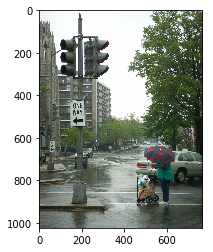

In [211]:
'/Users/davidheller/Object-detection-using-Faster-RCNN/createddata/test_annotation.txt'